In [53]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as  mpl

In [54]:
mpl.rcParams[u'font.sans-serif'] = ['simhei']
mpl.rcParams['axes.unicode_minus'] = False

In [55]:
def readData(y,s,c):
    df = pd.read_csv("lvr_land/"+ y +"-s" + s + "/" + c + "_lvr_land_A.csv",encoding='utf-8',low_memory=False)
    return df

In [56]:
def combineDF(df1,df2):
    df = pd.concat([df1,df2],axis = 0)
    return df

In [57]:
def selectFarmland(df):
    
    df = df[["鄉鎮市區","土地移轉總面積(平方公尺)","交易標的","都市土地使用分區","非都市土地使用分區","非都市土地使用編定","總價(元)","單價(元/平方公尺)"]]
    df = df[(df.交易標的 == "土地")]  
    df_farmland = df[(((df.非都市土地使用分區 == '特定農業區')|(df.非都市土地使用分區 == "一般農業區"))&(df.非都市土地使用編定 =="農牧用地"))]
    #排除都市土地
    df_farmland = df_farmland[df_farmland["都市土地使用分區"].isnull()]
    return df_farmland

In [58]:
def fillNanprice(df_farmland):
    #modify zero or nan price
    df_ok = df_farmland[(df_farmland["單價(元/平方公尺)"].notnull())&(df_farmland["單價(元/平方公尺)"] != "0")]
    df = df_farmland[(df_farmland["單價(元/平方公尺)"].isnull())|(df_farmland["單價(元/平方公尺)"] == "0")]
    df = df[(df['土地移轉總面積(平方公尺)'] != "0")&(df['總價(元)'] != "0")]
    df["單價(元/平方公尺)"] = calculateprice(df['總價(元)'],df['土地移轉總面積(平方公尺)'])
    df_farmland = pd.concat([df_ok,df],axis = 0)
    return df_farmland

In [59]:
def calculateprice(total_price,area):
    return pd.to_numeric(total_price)/pd.to_numeric(area)

In [60]:
def calculateMean(df_farmland):

    landpriceMean = pd.to_numeric(df_farmland['單價(元/平方公尺)']).mean()
   
    return landpriceMean

In [61]:
def calculateGain(cityMeandict,div):
    
    #dict to df
    arr = list(cityMeandict.items())
    df = pd.DataFrame(arr, columns=['年份','單價'])
    
    #  #逐年漲幅
    gain = df["單價"].pct_change(div)
    
    return gain

In [62]:
def grouptown_calculateMean(df,list_all_town):
    
    grouped=pd.to_numeric(df['單價(元/平方公尺)']).groupby(df['鄉鎮市區'])
    town_dict = {}
    for key,group in grouped:  
        m = grouped.mean()
        town_dict[key]= m[key]*3.3058 #1ping = 3.3058 m^2
        if key not in list_all_town:
            list_all_town.append(key)
    return {"towndict":town_dict,"town_list":list_all_town}

In [63]:
def plottown_average(towndict,list_all_town):
    list_color = ['#393b79','#5254a3','#6b6ecf','#9c9ede','#637939','#8ca252','#b5cf6b','#cedb9c','#8c6d31','#bd9e39','#e7ba52','#e7cb94','#843c39','#ad494a','#d6616b','#e7969c','#7b4173','#a55194','#ce6dbd','#de9ed6','#3182bd','#6baed6','#9ecae1','#c6dbef','#e6550d','#fd8d3c','#fdae6b','#fdd0a2','#e6550d','#fd8d3c','#fdae6b','#fdd0a2','#636363','#969696','#bdbdbd','#d9d9d9']
    color = 0
    for town in list_all_town: 
        town_year_dict = {}
        for key in towndict:   
            if town in towndict[key]:
                town_year_dict[key] = towndict[key][town]
        
        plt.plot(town_year_dict.keys(),town_year_dict.values(),marker='o',linestyle='solid',label=town if(town!='fa72埔鄉')else'鹽埔鄉')
        
        plt.xticks(range(len(towndict)), towndict.keys(),rotation=90) 
        plt.xlabel("年")
        plt.ylabel("(元/平方公尺)")
        plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
        plt.subplots_adjust(right=0.7)
        plt.title(list_city[i] + " "+"各鄉鎮市區"+"單價")
        plt.grid()
        plt.savefig("town-"+list_city[i])
        plt.show()
        color = color + 1
        
        for i in range(101,108):
            print("|"+str(i)+"|",end='')
            if np.isnan(town_year_dict[i]) == False:
                print(str(town_year_dict[i])+"|") 
            else:
                print("-|")

In [64]:
list_cityfilename = ['A','B','C','D','E','F','G','H','J','K','M','N','P','Q','T','U','V']
list_city = ['台北市','台中市','基隆市','台南市','高雄市','新北市','宜蘭縣','桃園縣','新竹縣','苗栗縣','南投縣','彰化縣','雲林縣','嘉義縣','屏東縣','花蓮縣','台東縣']

#combine嘉義縣市(Q,I) 新竹縣市(J,O)

i=0
taiwan = {} #各縣市逐年平均
city_gain = {} #縣市逐年漲幅
全國縣市單價 = {}
for c in list_cityfilename: #every city
    
    s = 4 # from 101-s4 to 107-s2
    cityMeandict = {} #各城市逐年平均
    townMeandict = {} #各鄉鎮逐年平均
    list_all_town = [] #該城市的鄉鎮列表
    for y in range(101,108): #every year
        df = pd.DataFrame()
        
        while s <= 4:
            # read data
            df_s =  readData(str(y),str(s),c)
            
            if c=='Q':# combine嘉義縣市(Q,I) 
                df_s = combineDF(df_s,readData(str(y),str(s),'I'))
            if c=='J':# combine新竹縣市(J,O)   
                df_s = combineDF(df_s,readData(str(y),str(s),'O'))
               
            df = combineDF(df,df_s)
            
            if y == 107 and s == 2:
                break
            s = s+1
        s=1
        # select farmland
        df_farmland = selectFarmland(df)
        # fill nan price
        df_farmland = fillNanprice(df_farmland)
        
        # 縣市年的平均
        mean = calculateMean(df_farmland)
        cityMeandict[str(y)] = mean*3.3058 #1ping = 3.3058 m^2
       
        # 鄉鎮
        result = grouptown_calculateMean(df_farmland,list_all_town)
        townMeandict[str(y)] = result["towndict"]
    全國縣市單價[list_city[i]] = cityMeandict
    
    print(list_city[i])
    #各鄉鎮逐年單價排名
    print("各鄉鎮逐年單價排名:")
    table_dict = {}
    for y in range(101,108):
        sorted_town = sorted(townMeandict[str(y)].items(),key = lambda s:s[1],reverse=True)
        table_dict[y] = sorted_town
   
    print("|排名\年",end='')
    for y in range(101,108):
        print("|"+str(y),end='')
    print("|")
    for y in range(101,108):
        print("|------",end='')
    print("|")
    for t in range(len(list_all_town)):
        print("|"+str(t+1)+"|",end='')
        for y in range(101,108):
            if t < len(table_dict[y]):
                print(table_dict[y][t][0]+" / "+"{:.1f}".format(table_dict[y][t][1])+"|",end="") 
            else:
                print("-|",end="")
        print("")
    
#     #鄉鎮逐年漲幅
#     print("鄉鎮逐年漲幅")
#     鄉鎮逐年平均單價={}
#     鄉鎮歷年平均單價 = {}
#     鄉鎮年度漲幅 = {}
#     鄉鎮逐年漲幅 = {}
#     for t in list_all_town:
#         鄉鎮逐年平均單價 = {}
#         for y in range(101,108):
#             if t in townMeandict[str(y)].keys():
#                 鄉鎮逐年平均單價[y] = townMeandict[str(y)][t]
#         鄉鎮歷年平均單價[t] = 鄉鎮逐年平均單價
      
#         gain = calculateGain(鄉鎮歷年平均單價[t],1)
#         year_list = list(鄉鎮歷年平均單價[t].keys())
        
#         y=0
#         鄉鎮逐年漲幅 = {}
#         for g in gain:
#             鄉鎮逐年漲幅[year_list[y]] = g
#             y+=1
#         鄉鎮年度漲幅[t] = 鄉鎮逐年漲幅
    
#     for_sort = {}
#     各年漲幅 = {}
#     sorted_gain = {}
#     for y in range(102,108):
#         for_sort = {}
#         for t in list_all_town:
#             if y in 鄉鎮年度漲幅[t].keys():
#                 for_sort[t] = 鄉鎮年度漲幅[t][y]
#         各年漲幅[y] = for_sort

#     for y in range(102,108):
#         sorted_gain[y] = sorted(各年漲幅[y].items(),key=lambda s:s[1],reverse=True)
    
#     sorted_dict = {}
#     for y in range(102,108):
#         sorted_dict[y] = dict(sorted_gain[y])
        
#     for s in list_all_town:
#         print("|"+str(s),end="")
#     print("|")
#     for s in list_all_town:
#         print("|------",end="")
#     print("|")
    
#     for y in range(102,108):
#         print("|"+str(y)+"|",end='')
#         for t in list_all_town:
#             if t in sorted_dict[y].keys():
#                 print("{:.1f}".format(sorted_dict[y][t]*100)+"|",end='')  
#             else:
#                 print("-|",end='')
#         print("")
        
    #鄉鎮總漲幅
    print("鄉鎮總漲幅:")
    鄉鎮逐年平均單價={}
    鄉鎮歷年平均單價 = {}
    鄉鎮年度漲幅 = {}
    鄉鎮逐年漲幅 = {}
    for t in list_all_town:
        鄉鎮逐年平均單價 = {}
        for y in range(101,108):
            if t in townMeandict[str(y)].keys():
                鄉鎮逐年平均單價[y] = townMeandict[str(y)][t]
        鄉鎮歷年平均單價[t] = 鄉鎮逐年平均單價
      
        gain = calculateGain(鄉鎮歷年平均單價[t],len(鄉鎮歷年平均單價[t].keys())-1)
        for g in gain:
            if np.isnan(g) == False:
                 鄉鎮年度漲幅[t] = g
    
    sorted_gain = sorted(鄉鎮年度漲幅.items(),key=lambda s:s[1],reverse=True)

    print("|排名\年|107|")

    print("|------|------|")
    for h in range(len(鄉鎮年度漲幅.keys())):
        print("|"+str(h)+"|",end="")  
        print(sorted_gain[h][0]+"/"+"{:.1f}".format(sorted_gain[h][1]*100)+"|")     
      
    i = i+1
    

台北市
各鄉鎮逐年單價排名:
|排名\年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|
鄉鎮總漲幅:
|排名\年|107|
|------|------|
台中市
各鄉鎮逐年單價排名:
|排名\年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|
|1|大雅區 / 57949.6|大里區 / 65717.8|大里區 / 72093.0|潭子區 / 97199.6|豐原區 / 61956.4|潭子區 / 68162.7|潭子區 / 165290.0|
|2|太平區 / 49319.2|大雅區 / 58547.9|大雅區 / 67695.4|大里區 / 77083.7|潭子區 / 61123.8|大里區 / 60252.6|大里區 / 61720.3|
|3|大里區 / 47437.7|烏日區 / 53317.6|龍井區 / 65716.5|大雅區 / 65312.5|太平區 / 60241.0|豐原區 / 57353.5|太平區 / 51960.6|
|4|烏日區 / 39867.9|龍井區 / 50515.5|潭子區 / 56271.1|龍井區 / 56752.5|大里區 / 54583.5|龍井區 / 55182.1|豐原區 / 51081.8|
|5|沙鹿區 / 35854.7|太平區 / 45071.3|太平區 / 53040.9|烏日區 / 51640.2|龍井區 / 54403.1|大雅區 / 47994.1|龍井區 / 44917.0|
|6|霧峰區 / 29084.2|豐原區 / 44185.3|烏日區 / 50152.7|霧峰區 / 45269.1|烏日區 / 50255.2|烏日區 / 43640.2|神岡區 / 40649.2|
|7|新社區 / 28840.2|霧峰區 / 38591.3|霧峰區 / 47421.8|豐原區 / 44847.0|大雅區 / 49744.3|霧峰區 / 43543.5|大雅區 / 39560.5|
|8|神岡區 / 21980.3|沙鹿區 / 35496.3|豐原區 / 45430.7|太平區 

新北市
各鄉鎮逐年單價排名:
|排名\年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|
|1|樹林區 / 41358.9|泰山區 / 284976.5|新莊區 / 226006.5|新莊區 / 399938.3|新莊區 / 288989.7|新莊區 / 266592.9|五股區 / 117387.0|
|2|三峽區 / 29149.4|五股區 / 117297.7|五股區 / 167955.2|泰山區 / 279968.2|泰山區 / 181719.8|泰山區 / 243244.1|三峽區 / 98834.6|
|3|鶯歌區 / 23355.5|樹林區 / 46101.9|板橋區 / 125002.2|五股區 / 186744.4|五股區 / 165880.9|五股區 / 152667.9|樹林區 / 69129.5|
|4|三芝區 / 10909.1|三峽區 / 42451.0|泰山區 / 80330.9|深坑區 / 77544.2|樹林區 / 64556.7|樹林區 / 68967.3|鶯歌區 / 49404.5|
|5|金山區 / 9596.7|鶯歌區 / 25852.5|三峽區 / 65011.6|樹林區 / 60603.6|深坑區 / 61191.2|三峽區 / 51038.9|淡水區 / 16619.2|
|6|淡水區 / 9586.8|深坑區 / 22340.6|樹林區 / 51131.2|三峽區 / 49448.2|三峽區 / 50323.1|鶯歌區 / 44239.2|深坑區 / 16529.0|
|7|-|淡水區 / 15844.7|深坑區 / 50089.5|鶯歌區 / 33318.6|鶯歌區 / 41667.6|金山區 / 15506.8|金山區 / 13137.2|
|8|-|金山區 / 13237.2|平溪區 / 39887.8|淡水區 / 17121.3|淡水區 / 20080.2|淡水區 / 13541.2|三芝區 / 10454.6|
|9|-|三芝區 / 12593.0|鶯歌區 / 24454.4|金山區 / 16677.0|三芝區 / 16821.3|三芝區 / 8988.0|雙溪區 / 6382.4|
|10|-|

彰化縣
各鄉鎮逐年單價排名:
|排名\年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|
|1|彰化市 / 39146.5|彰化市 / 29432.7|彰化市 / 34032.0|彰化市 / 36032.6|彰化市 / 27678.0|彰化市 / 33249.1|和美鎮 / 27990.9|
|2|芬園鄉 / 22083.9|芬園鄉 / 22108.0|芬園鄉 / 26196.6|芬園鄉 / 25806.3|花壇鄉 / 24440.3|和美鎮 / 23174.4|員林市 / 26363.4|
|3|永靖鄉 / 20987.9|員林市 / 17037.3|和美鎮 / 18927.9|花壇鄉 / 18983.3|芬園鄉 / 24182.7|芬園鄉 / 22827.7|彰化市 / 24900.9|
|4|花壇鄉 / 17623.8|和美鎮 / 16340.4|花壇鄉 / 17760.9|和美鎮 / 18829.6|員林市 / 18980.7|員林市 / 22411.9|秀水鄉 / 18102.4|
|5|和美鎮 / 16240.3|大村鄉 / 15403.8|員林市 / 17418.0|員林市 / 18377.4|和美鎮 / 18503.5|花壇鄉 / 22168.0|鹿港鎮 / 17368.3|
|6|員林市 / 11770.6|花壇鄉 / 15025.8|大村鄉 / 14868.5|埔心鄉 / 15086.5|秀水鄉 / 16438.0|秀水鄉 / 18650.8|花壇鄉 / 17263.3|
|7|秀水鄉 / 10713.3|秀水鄉 / 11796.4|秀水鄉 / 13988.9|永靖鄉 / 14858.6|伸港鄉 / 15358.3|埔心鄉 / 16941.3|芬園鄉 / 14787.6|
|8|伸港鄉 / 10501.2|永靖鄉 / 11754.5|埔心鄉 / 13367.1|秀水鄉 / 14644.2|鹿港鎮 / 14010.0|大村鄉 / 15823.0|社頭鄉 / 13852.7|
|9|鹿港鎮 / 10294.4|埔心鄉 / 11342.4|伸港鄉 / 11937.2|大村鄉 / 13854.5|大村鄉 / 14003.4|永靖鄉 / 1542

花蓮縣
各鄉鎮逐年單價排名:
|排名\年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|
|1|花蓮市 / 11075.8|吉安鄉 / 10239.3|花蓮市 / 12265.8|花蓮市 / 16146.7|吉安鄉 / 14266.3|吉安鄉 / 17769.0|花蓮市 / 15753.8|
|2|吉安鄉 / 8664.6|新城鄉 / 6802.9|吉安鄉 / 11745.8|吉安鄉 / 14461.9|新城鄉 / 12260.7|花蓮市 / 13808.1|吉安鄉 / 14150.6|
|3|新城鄉 / 7488.3|花蓮市 / 6739.8|新城鄉 / 8585.6|新城鄉 / 11807.8|花蓮市 / 11558.2|新城鄉 / 10935.8|新城鄉 / 11568.2|
|4|壽豐鄉 / 4696.4|壽豐鄉 / 5316.2|壽豐鄉 / 6647.2|壽豐鄉 / 8504.6|壽豐鄉 / 8357.4|壽豐鄉 / 6901.4|壽豐鄉 / 7680.6|
|5|秀林鄉 / 3236.4|富里鄉 / 4480.5|瑞穗鄉 / 6006.3|瑞穗鄉 / 6214.3|瑞穗鄉 / 6206.5|鳳林鎮 / 4830.3|瑞穗鄉 / 6347.5|
|6|鳳林鎮 / 3061.5|瑞穗鄉 / 3897.3|鳳林鎮 / 4239.6|鳳林鎮 / 5257.4|鳳林鎮 / 4840.8|瑞穗鄉 / 4484.5|鳳林鎮 / 5073.3|
|7|瑞穗鄉 / 2303.0|鳳林鎮 / 3817.8|玉里鎮 / 2673.0|玉里鎮 / 3832.4|秀林鄉 / 3811.0|玉里鎮 / 3220.6|秀林鄉 / 4357.0|
|8|玉里鎮 / 1719.7|玉里鎮 / 2147.4|富里鄉 / 2525.3|富里鄉 / 3587.4|富里鄉 / 3233.4|光復鄉 / 3101.1|玉里鎮 / 3600.6|
|9|光復鄉 / 1465.6|秀林鄉 / 2047.9|秀林鄉 / 2422.3|秀林鄉 / 3184.3|光復鄉 / 3040.0|秀林鄉 / 2686.3|富里鄉 / 2939.8|
|10|-|光復鄉 / 1941.8|光復鄉 / 219

In [65]:
#縣市總漲幅
print("縣市總漲幅:")
縣市逐年漲幅={}
for t in list_city:
    gain = calculateGain(全國縣市單價[t],6)#總漲幅 argu2 = 6
    y=101
    年度漲幅 = {}
    for g in gain:
        年度漲幅[y] = g
        y=y+1
    縣市逐年漲幅[t] = 年度漲幅
for_sort = {}
各年漲幅 = {}
sorted_gain = {}
for y in range(102,108):
    for_sort = {}
    for t in list_city:
        for_sort[t] = 縣市逐年漲幅[t][y]
    各年漲幅[y] = for_sort

for y in range(102,108):
    sorted_gain[y] = sorted(各年漲幅[y].items(),key=lambda s:s[1],reverse=True)

print("|排名\年|漲幅|")

print("|------|------|")

for i in range(0,17):
    if np.isnan(sorted_gain[y][i][1]) == False:
        print("|"+str(i-1),end="")
        print("|"+sorted_gain[y][i][0]+"/"+ "{:.1f}".format(sorted_gain[y][i][1]*100)+"|")


縣市總漲幅:
|排名\年|漲幅|
|------|------|
|1|新北市/110.0|
|2|台東縣/100.4|
|3|苗栗縣/56.8|
|4|高雄市/44.5|
|5|屏東縣/44.4|
|6|彰化縣/33.2|
|7|雲林縣/28.2|
|8|台南市/22.5|
|9|花蓮縣/21.9|
|10|宜蘭縣/18.8|
|11|台中市/17.4|
|12|南投縣/13.4|
|13|桃園縣/10.3|
|14|嘉義縣/9.0|
|15|新竹縣/-24.6|


各縣市單價
台北市


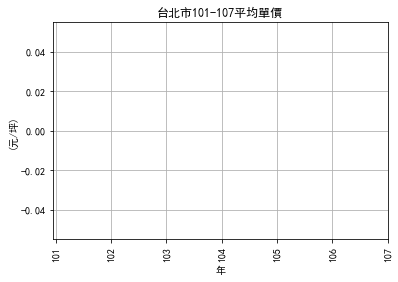

|年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|------|
|元/坪|nan|nan|nan|nan|nan|nan|nan|
台中市


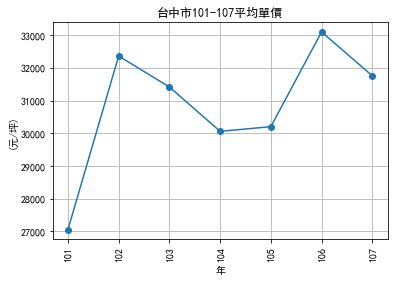

|年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|------|
|元/坪|27053.1|32361.7|31414.7|30058.4|30200.7|33098.5|31757.2|
基隆市


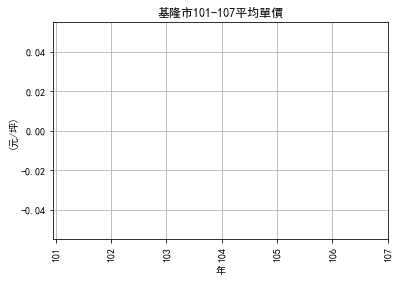

|年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|------|
|元/坪|nan|nan|nan|nan|nan|nan|nan|
台南市


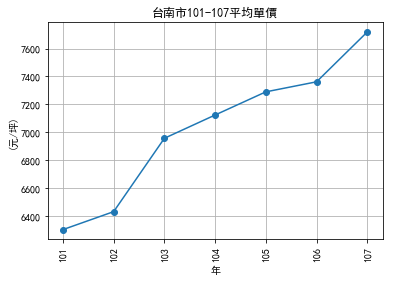

|年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|------|
|元/坪|6302.6|6431.4|6957.0|7123.7|7289.7|7361.6|7718.9|
高雄市


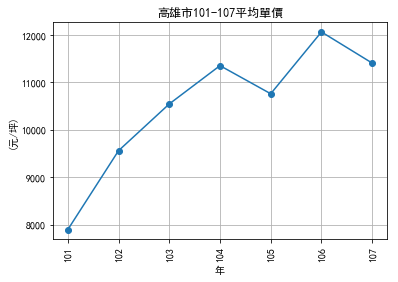

|年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|------|
|元/坪|7895.3|9558.8|10544.1|11351.9|10759.2|12062.5|11405.8|
新北市


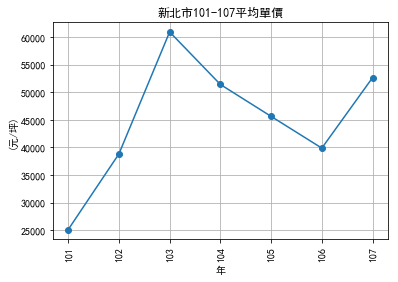

|年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|------|
|元/坪|25080.2|38821.7|60975.4|51439.1|45640.2|39876.2|52670.1|
宜蘭縣


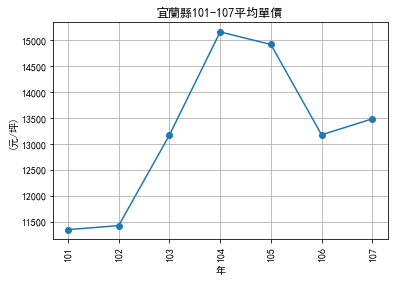

|年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|------|
|元/坪|11349.2|11425.6|13167.0|15153.4|14912.5|13173.6|13480.7|
桃園縣


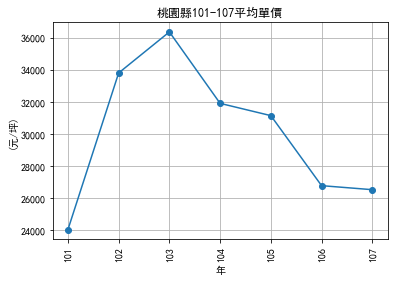

|年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|------|
|元/坪|24038.6|33801.6|36358.2|31905.6|31141.7|26777.5|26526.4|
新竹縣


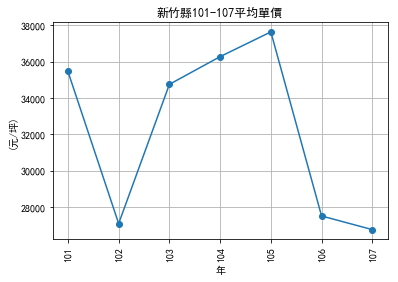

|年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|------|
|元/坪|35463.0|27087.0|34753.5|36279.1|37639.3|27504.9|26754.9|
苗栗縣


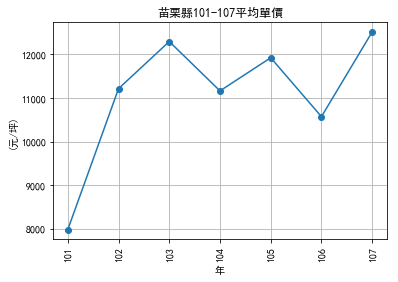

|年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|------|
|元/坪|7981.9|11213.2|12293.5|11162.0|11921.6|10571.2|12513.2|
南投縣


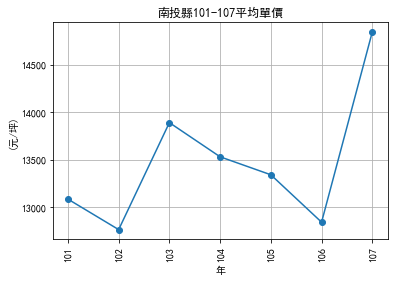

|年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|------|
|元/坪|13083.8|12763.2|13888.6|13528.9|13340.0|12841.2|14842.8|
彰化縣


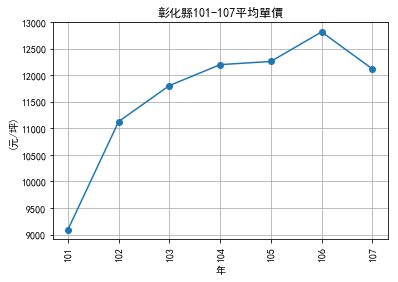

|年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|------|
|元/坪|9095.0|11127.1|11803.1|12196.7|12256.5|12811.8|12117.5|
雲林縣


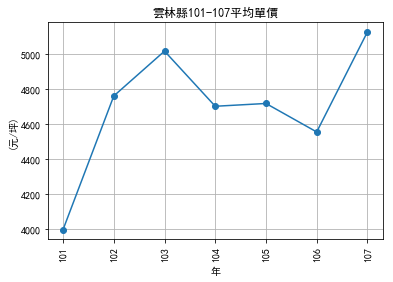

|年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|------|
|元/坪|3996.7|4759.9|5016.0|4701.1|4717.0|4554.4|5125.6|
嘉義縣


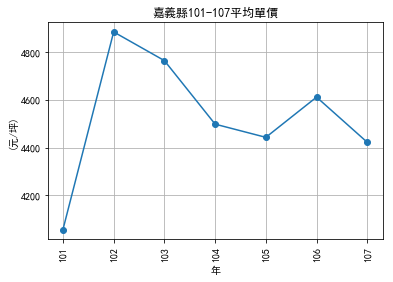

|年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|------|
|元/坪|4057.2|4883.5|4763.6|4498.0|4442.9|4611.0|4422.1|
屏東縣


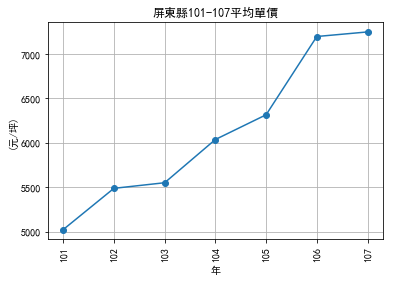

|年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|------|
|元/坪|5021.6|5486.9|5550.0|6037.2|6316.0|7198.4|7249.9|
花蓮縣


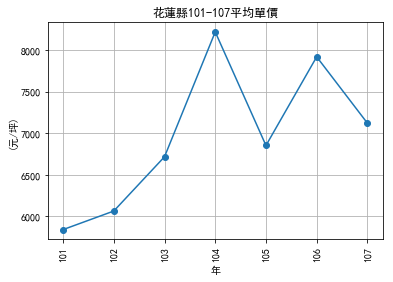

|年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|------|
|元/坪|5841.0|6064.5|6717.4|8219.9|6853.3|7920.2|7121.7|
台東縣


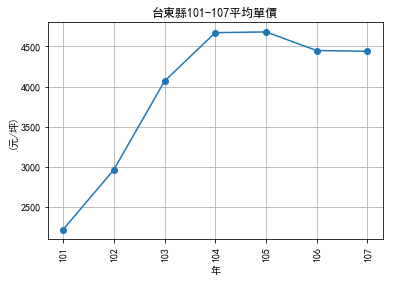

|年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|------|
|元/坪|2215.4|2961.5|4067.5|4672.2|4681.1|4449.2|4439.6|


In [66]:
print("各縣市單價")
for i in list_city:
    print(i)
    plt.plot(全國縣市單價[i].keys(),全國縣市單價[i].values(),marker='o',linestyle='solid')    
    plt.xticks(range(len(全國縣市單價[i])), 全國縣市單價[i].keys(),rotation=90) 
    plt.xlabel("年")
    plt.ylabel("(元/坪)")
    plt.title(i + "101-107平均單價")
    plt.grid()
    plt.savefig(i + "101-107平均單價")
    plt.show()
    
    print("|年",end='')
    for y in range(101,108):
        print("|"+str(y),end='')
    print("|")
    for y in range(101,109):
        print("|------",end='')
    print("|")
    print("|元/坪",end='')
    for h in range(101,108):
        print("|"+"{:.1f}".format(全國縣市單價[i][str(h)]),end='')
    print("|")

In [67]:
#縣市逐年排名
print("縣市逐年排名")
average_dict = {}
for y in range(101,108): 
    average_rank = []
    for c in list_city:      
        average_rank.append((c,全國縣市單價[c][str(y)]))
    average_rank = sorted(average_rank, key=lambda s:s[1], reverse=True)
    average_dict[y] = average_rank

print("|排名\年",end='')
for i in range(101,108):
    print("|"+str(i),end='')
print("|")
for i in range(101,109):
    print("|------",end='')
print("|")
for i in range(len(list_city)):
    if np.isnan(average_dict[y][i][1]) == False:
        print("|"+str(i-1),end='')
        for y in range(101,108):
            print("|"+average_dict[y][i][0]+" / "+"{:.1f}".format(average_dict[y][i][1]),end='')
        print("|")
    

縣市逐年排名
|排名\年|101|102|103|104|105|106|107|
|------|------|------|------|------|------|------|------|
|1|新竹縣 / 35463.0|新北市 / 38821.7|新北市 / 60975.4|新北市 / 51439.1|新北市 / 45640.2|新北市 / 39876.2|新北市 / 52670.1|
|2|台中市 / 27053.1|桃園縣 / 33801.6|桃園縣 / 36358.2|新竹縣 / 36279.1|新竹縣 / 37639.3|台中市 / 33098.5|台中市 / 31757.2|
|3|新北市 / 25080.2|台中市 / 32361.7|新竹縣 / 34753.5|桃園縣 / 31905.6|桃園縣 / 31141.7|新竹縣 / 27504.9|新竹縣 / 26754.9|
|4|桃園縣 / 24038.6|新竹縣 / 27087.0|台中市 / 31414.7|台中市 / 30058.4|台中市 / 30200.7|桃園縣 / 26777.5|桃園縣 / 26526.4|
|5|南投縣 / 13083.8|南投縣 / 12763.2|南投縣 / 13888.6|宜蘭縣 / 15153.4|宜蘭縣 / 14912.5|宜蘭縣 / 13173.6|南投縣 / 14842.8|
|6|宜蘭縣 / 11349.2|宜蘭縣 / 11425.6|宜蘭縣 / 13167.0|南投縣 / 13528.9|南投縣 / 13340.0|南投縣 / 12841.2|宜蘭縣 / 13480.7|
|7|彰化縣 / 9095.0|苗栗縣 / 11213.2|苗栗縣 / 12293.5|彰化縣 / 12196.7|彰化縣 / 12256.5|彰化縣 / 12811.8|苗栗縣 / 12513.2|
|8|苗栗縣 / 7981.9|彰化縣 / 11127.1|彰化縣 / 11803.1|高雄市 / 11351.9|苗栗縣 / 11921.6|高雄市 / 12062.5|彰化縣 / 12117.5|
|9|高雄市 / 7895.3|高雄市 / 9558.8|高雄市 / 10544.1|苗栗縣 / 11162.0|高雄市 / 10759.2|苗栗縣 / 10571.2|高

In [69]:
list_cityfilename = ['A','B','C','D','E','F','G','H','J','K','M','N','P','Q','T','U','V']
list_city = ['台北市','台中市','基隆市','台南市','高雄市','新北市','宜蘭縣','桃園縣','新竹縣','苗栗縣','南投縣','彰化縣','雲林縣','嘉義縣','屏東縣','花蓮縣','台東縣']

#list_city  = ['花蓮縣','苗栗縣','新竹縣','台東縣','屏東縣',]
#list_cityfilename = ['U','K','J','V','T']
#combine嘉義縣市(Q,I) 新竹縣市(J,O)

i=0
taiwan = {} #各縣市逐年平均
city_gain = {} #縣市逐年漲幅
全國縣市單價 = {}
for c in list_cityfilename: #every city
    
    s = 4 # from 101-s4 to 107-s2
    cityMeandict = {} #各城市逐年平均
    townMeandict = {} #各鄉鎮逐年平均
    list_all_town = [] #該城市的鄉鎮列表
    for y in range(101,108): #every year
        df = pd.DataFrame()
        
        while s <= 4:
            # read data
            df_s =  readData(str(y),str(s),c)
            
            if c=='Q':# combine嘉義縣市(Q,I) 
                df_s = combineDF(df_s,readData(str(y),str(s),'I'))
            if c=='J':# combine新竹縣市(J,O)   
                df_s = combineDF(df_s,readData(str(y),str(s),'O'))
               
            df = combineDF(df,df_s)
         
            # select farmland
            df_farmland = selectFarmland(df)
            # fill nan price
            df_farmland = fillNanprice(df_farmland)
        
            # 縣市年的平均
            mean = calculateMean(df_farmland)
            cityMeandict[str(y)+'-'+str(s)] = mean*3.3058 #1ping = 3.3058 m^2
            
               
            if y == 107 and s == 2:
                break
            s = s+1
        s=1
       
        
    全國縣市單價[list_city[i]] = cityMeandict
    i+=1